In [1]:
from read_mias import *
from denoise import *
from orient import *
from rm_pec import *
import matplotlib.pyplot as plt
import cv2 as cv
from scipy.signal import convolve2d

path = 'mias_data'
data = read_mias(path)
oriented = reorient_all(data)
denoised = denoise_all(oriented)


In [2]:
def rm_pec(img, background_thresh = 30):
    kernel = np.array([[1/9,1/9,1/9],
                   [1/9,1/9,1/9],
                   [1/9,1/9,1/9]])
    conv = convolve2d(img, kernel, mode = 'same')
    ret, thresh = cv.threshold(img, 5,255, cv.THRESH_BINARY)
    cnts, _ = cv.findContours(thresh.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    c = cnts[0]
    extLeft = tuple(c[c[:,:,0].argmin()][0])
    extRight = tuple(c[c[:,:,0].argmax()][0])
    a = int(extRight[0] - 20)
    b = int(extRight[0])
    rowmeans = img[:, a:b].mean(axis = 1)
    rowmaxes = img[:, a:b].max(axis = 1)
    mcontours = []
    for L1 in range(img.shape[0] -1):
        L2 = L1+1
        rowsmaxL = rowmaxes[[int(L1),int(L2)]].max()
        rowsmeanL = rowmeans[[int(L1),int(L2)]].mean()
        localthresh = 64 + ((rowsmeanL * 0.7 + rowsmaxL * 0.3)/2)
        pts = []
        i = extRight[0] - 20  
        val = conv[L1, i]
        if rowsmaxL > background_thresh:
            while val > localthresh:
                pts.append(i)
                i += -1
                val = conv[L1, i]
            else:
                mcontours.append((L1, i))
                
            
    return mcontours


192.0
209


[]

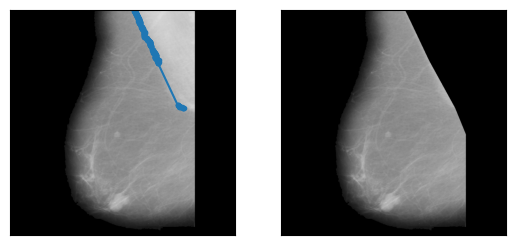

In [3]:
idx =4
img = denoised[idx]
background_thresh = np.percentile(img, 99)
print(background_thresh)
pts = pec_cntrs(img, background_thresh)
print(len(pts))
ys = [x[0] for x in pts]
xs = [x[1] for x in pts]
if len(pts) > 5:
    img_new = rm_cntrs(img, pts)
else:
    img_new = img
fig, axs = plt.subplots(1,2)
axs[0].imshow(img,cmap = 'gray')
axs[0].plot(xs, ys, marker = '.')
axs[1].imshow(img_new, cmap = 'gray')
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[1].set_xticks([])
axs[1].set_yticks([])

In [4]:
removed_pec = rm_pec_all(denoised)


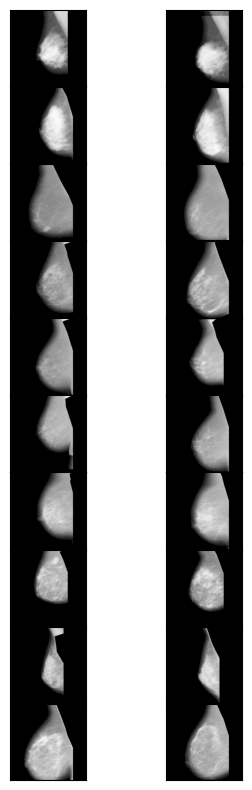

In [5]:
fig, axes = plt.subplots(10, 2, figsize = (4,10),
                         subplot_kw ={'xticks':[], 'yticks':[]},
                         gridspec_kw = dict(hspace=0.01, wspace = 0.01))
for i,ax in enumerate(axes.flat):
    ax.imshow(removed_pec[i],cmap = 'gray')

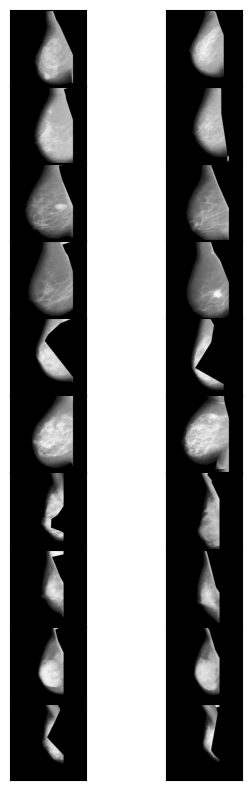

In [6]:
fig, axes = plt.subplots(10, 2, figsize = (4,10),
                         subplot_kw ={'xticks':[], 'yticks':[]},
                         gridspec_kw = dict(hspace=0.01, wspace = 0.01))
for i,ax in enumerate(axes.flat):
    ax.imshow(removed_pec[i + 20],cmap = 'gray')

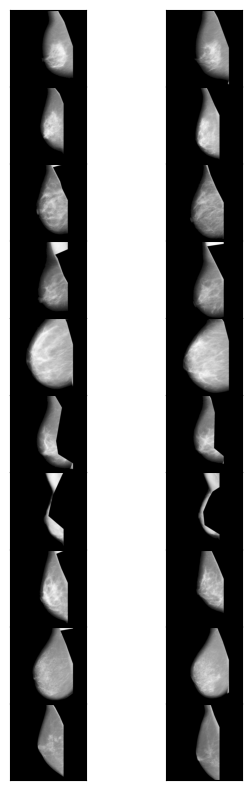

In [7]:
fig, axes = plt.subplots(10, 2, figsize = (4,10),
                         subplot_kw ={'xticks':[], 'yticks':[]},
                         gridspec_kw = dict(hspace=0.01, wspace = 0.01))
for i,ax in enumerate(axes.flat):
    ax.imshow(removed_pec[i + 40],cmap = 'gray')

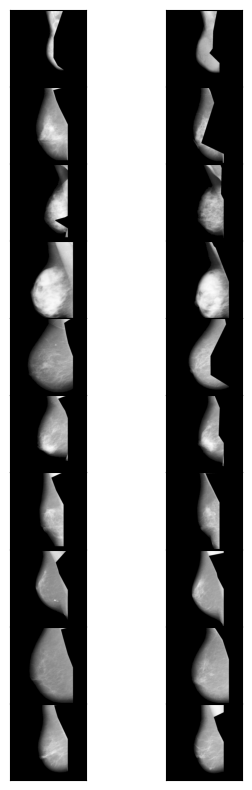

In [8]:
fig, axes = plt.subplots(10, 2, figsize = (4,10),
                         subplot_kw ={'xticks':[], 'yticks':[]},
                         gridspec_kw = dict(hspace=0.01, wspace = 0.01))
for i,ax in enumerate(axes.flat):
    ax.imshow(removed_pec[i + 60],cmap = 'gray')

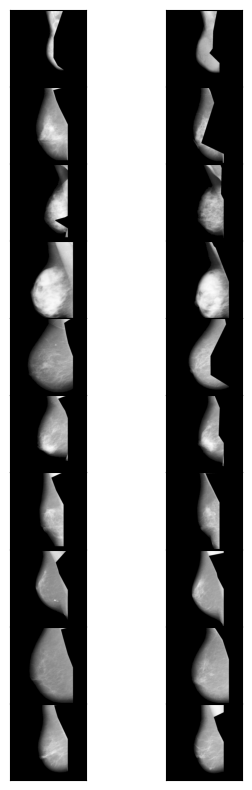

In [9]:
fig, axes = plt.subplots(10, 2, figsize = (4,10),
                         subplot_kw ={'xticks':[], 'yticks':[]},
                         gridspec_kw = dict(hspace=0.01, wspace = 0.01))
for i,ax in enumerate(axes.flat):
    ax.imshow(removed_pec[i + 60],cmap = 'gray')

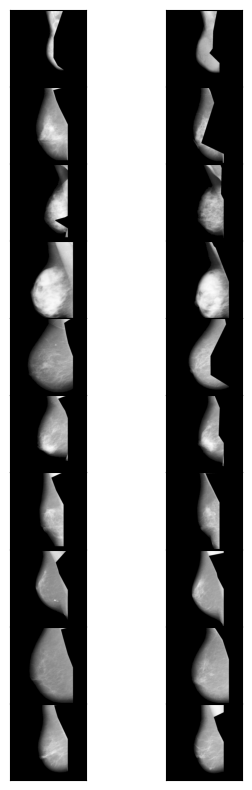

In [12]:
fig, axes = plt.subplots(10, 2, figsize = (4,10),
                         subplot_kw ={'xticks':[], 'yticks':[]},
                         gridspec_kw = dict(hspace=0.01, wspace = 0.01))
for i,ax in enumerate(axes.flat):
    ax.imshow(removed_pec[i + 60],cmap = 'gray')

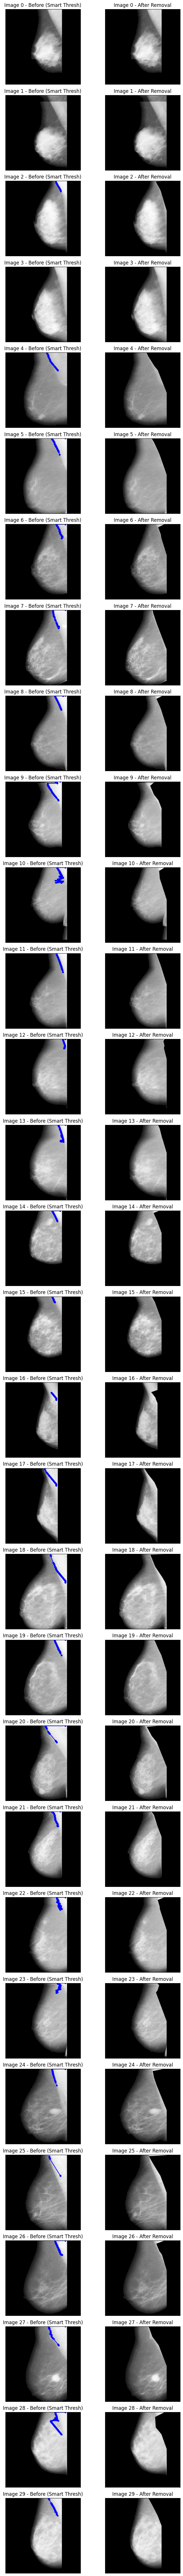

In [29]:
def rm_pec(img, background_thresh=30):
    # Restrict to upper-right triangular region only
    rows, cols = img.shape
    mask = np.zeros_like(img, dtype=np.uint8)
    pts_triangle = np.array([[cols, 0], [cols, int(rows * 0.6)], [int(cols * 0.5), 0]])
    cv.fillPoly(mask, [pts_triangle], 255)

    # Apply mask to the image BEFORE any processing
    img_masked = cv.bitwise_and(img, img, mask=mask)

    kernel = np.array([[1/9,1/9,1/9],
                       [1/9,1/9,1/9],
                       [1/9,1/9,1/9]])
    conv = convolve2d(img_masked, kernel, mode='same')
    ret, thresh = cv.threshold(img_masked, 5, 255, cv.THRESH_BINARY)
    cnts, _ = cv.findContours(thresh.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    if len(cnts) == 0:
        return []  # return empty contour

    c = cnts[0]
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    a = int(extRight[0] - 20)
    b = int(extRight[0])
    rowmeans = img_masked[:, a:b].mean(axis=1)
    rowmaxes = img_masked[:, a:b].max(axis=1)
    mcontours = []

    for L1 in range(img.shape[0] - 1):
        L2 = L1 + 1
        rowsmaxL = rowmaxes[[int(L1), int(L2)]].max()
        rowsmeanL = rowmeans[[int(L1), int(L2)]].mean()
        localthresh = 64 + ((rowsmeanL * 0.7 + rowsmaxL * 0.3) / 2)
        i = extRight[0] - 20  
        val = conv[L1, i]
        if rowsmaxL > background_thresh:
            while val > localthresh:
                i -= 1
                if i <= 0:
                    break
                val = conv[L1, i]
            else:
                mcontours.append((L1, i))

    return mcontours


# === Plotting all images ===
n_images = 30
fig, axs = plt.subplots(n_images, 2, figsize=(8, 3 * n_images))

for idx in range(n_images):
    img = denoised[idx]
    background_thresh = np.percentile(img, 99)
    pts = rm_pec(img, background_thresh)

    ys = [x[0] for x in pts]
    xs = [x[1] for x in pts]

    # Always attempt removal
    img_new = rm_cntrs(img, pts) if len(pts) > 0 else img

    axs[idx, 0].imshow(img, cmap='gray')
    if len(ys) > 0:
        axs[idx, 0].plot(xs, ys, marker='.', color='blue')
    axs[idx, 0].set_title(f"Image {idx} - Before (Smart Thresh)")

    axs[idx, 1].imshow(img_new, cmap='gray')
    axs[idx, 1].set_title(f"Image {idx} - After Removal")

    for ax in axs[idx]:
        ax.set_xticks([])
        ax.set_yticks([])

plt.tight_layout()
plt.show()


[Warning] Skipping image 0 due to no or weak contour
[Warning] Skipping image 1 due to no or weak contour
[Warning] Skipping image 3 due to no or weak contour
[Warning] Skipping image 0 due to no or weak contour
[Warning] Skipping image 1 due to no or weak contour
[Warning] Skipping image 3 due to no or weak contour


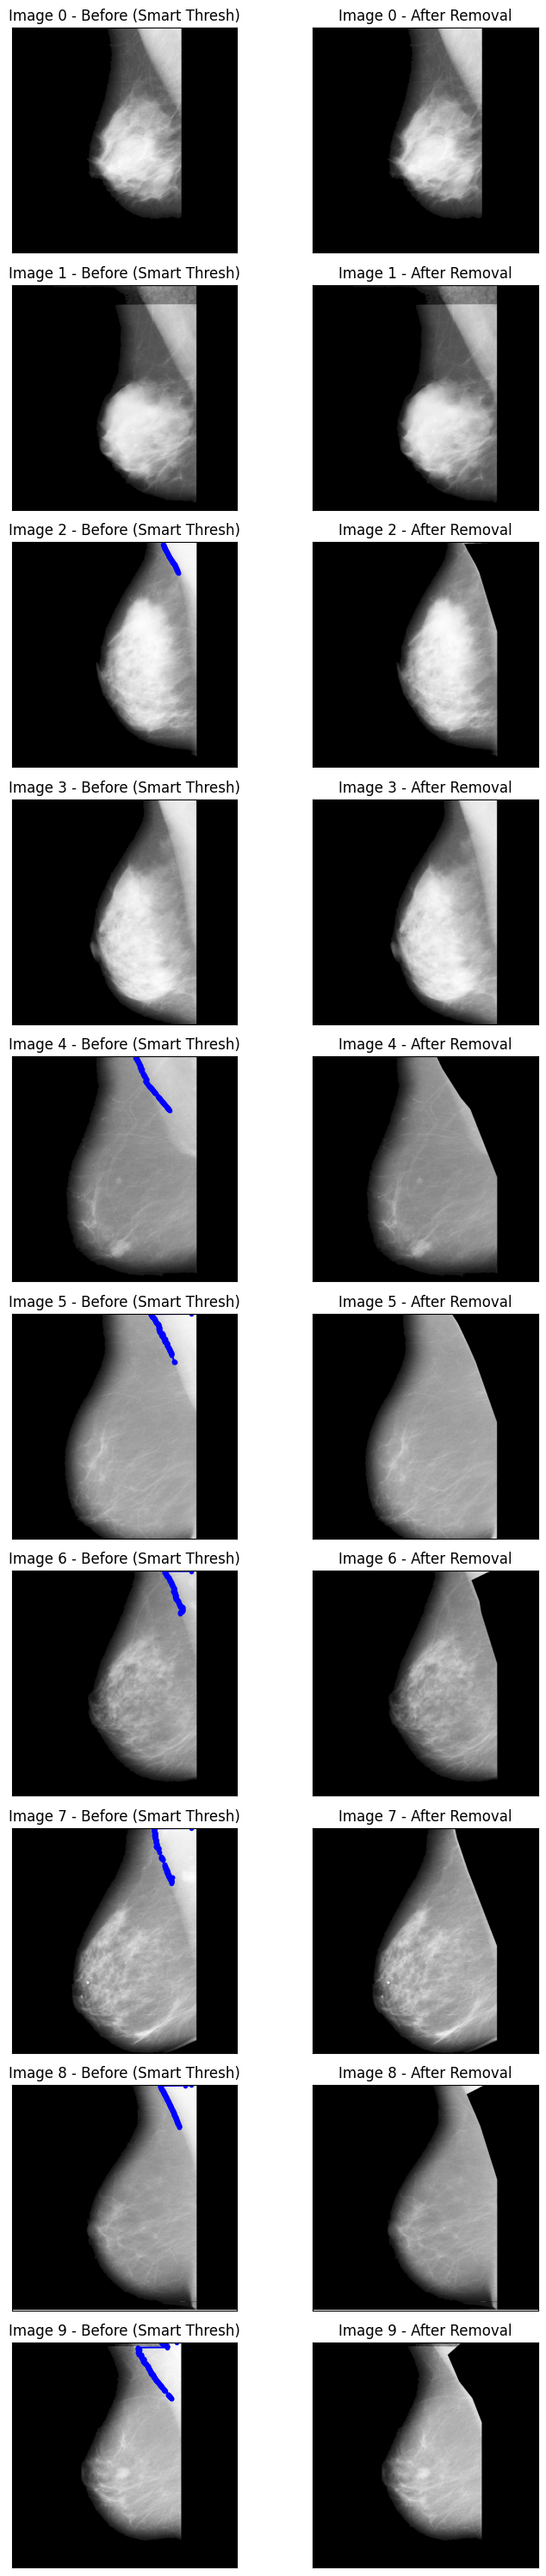

In [30]:
def rm_pec(img, background_thresh=30):
    # Restrict to upper-right triangular region only
    rows, cols = img.shape
    mask = np.zeros_like(img, dtype=np.uint8)
    pts_triangle = np.array([[cols, 0], [cols, int(rows * 0.6)], [int(cols * 0.5), 0]])
    cv.fillPoly(mask, [pts_triangle], 255)

    # Apply mask to the image BEFORE any processing
    img_masked = cv.bitwise_and(img, img, mask=mask)

    # Now use img_masked for the rest of your code
    kernel = np.array([[1/9,1/9,1/9],
                       [1/9,1/9,1/9],
                       [1/9,1/9,1/9]])
    conv = convolve2d(img_masked, kernel, mode='same')
    ret, thresh = cv.threshold(img_masked, 5, 255, cv.THRESH_BINARY)
    cnts, _ = cv.findContours(thresh.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    
    if len(cnts) == 0:
        return None  # defensive fallback
    
    c = cnts[0]
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    a = int(extRight[0] - 20)
    b = int(extRight[0])
    rowmeans = img_masked[:, a:b].mean(axis=1)
    rowmaxes = img_masked[:, a:b].max(axis=1)
    mcontours = []
    for L1 in range(img.shape[0] - 1):
        L2 = L1 + 1
        rowsmaxL = rowmaxes[[int(L1), int(L2)]].max()
        rowsmeanL = rowmeans[[int(L1), int(L2)]].mean()
        localthresh = 64 + ((rowsmeanL * 0.7 + rowsmaxL * 0.3) / 2)
        i = extRight[0] - 20  
        val = conv[L1, i]
        if rowsmaxL > background_thresh:
            while val > localthresh:
                i += -1
                if i <= 0:
                    break
                val = conv[L1, i]
            else:
                mcontours.append((L1, i))

    if len(mcontours) < 10:
        return None

    return mcontours

n_images = 10

for idx in range(n_images):
    img = denoised[idx]
    background_thresh = np.percentile(img, 99)
    pts = rm_pec(img, background_thresh)

    if pts is None or len(pts) < 10:
        print(f"[Warning] Skipping image {idx} due to no or weak contour")
        img_new = img
        ys, xs = [], []
    else:
        ys = [x[0] for x in pts]
        xs = [x[1] for x in pts]

        if np.std(np.diff(xs)) > 30 or np.std(np.diff(ys)) > 30:
            print(f"[Warning] Irregular contour at image {idx}")
            img_new = img
        else:
            img_new = rm_cntrs(img, pts)

    # Plotting remains as you have


n_images = 10
fig, axs = plt.subplots(n_images, 2, figsize=(8, 3 * n_images))

for idx in range(n_images):
    img = denoised[idx]
    background_thresh = np.percentile(img, 99)
    pts = rm_pec(img, background_thresh)

    # ✅ Defensive check if pts is None or too short
    if pts is None or len(pts) < 10:
        print(f"[Warning] Skipping image {idx} due to no or weak contour")
        img_new = img  # fallback to original
        ys, xs = [], []
    else:
        ys = [x[0] for x in pts]
        xs = [x[1] for x in pts]

        # Optional additional contour smoothness check:
        if np.std(np.diff(xs)) > 30 or np.std(np.diff(ys)) > 30:
            print(f"[Warning] Irregular contour at image {idx}")
            img_new = img
        else:
            img_new = rm_cntrs(img, pts)

    axs[idx, 0].imshow(img, cmap='gray')
    if len(ys) > 0:
        axs[idx, 0].plot(xs, ys, marker='.', color='blue')
    axs[idx, 0].set_title(f"Image {idx} - Before (Smart Thresh)")

    axs[idx, 1].imshow(img_new, cmap='gray')
    axs[idx, 1].set_title(f"Image {idx} - After Removal")

    for ax in axs[idx]:
        ax.set_xticks([])
        ax.set_yticks([])

plt.tight_layout()
plt.show()






[Warning] Skipping image 53 due to no or weak contour
[Warning] Skipping image 60 due to no or weak contour
[Warning] Skipping image 64 due to no or weak contour
[Warning] Skipping image 66 due to no or weak contour
[Warning] Skipping image 79 due to no or weak contour
[Warning] Skipping image 80 due to no or weak contour
[Warning] Skipping image 88 due to no or weak contour
[Warning] Skipping image 97 due to no or weak contour
[Warning] Skipping image 104 due to no or weak contour


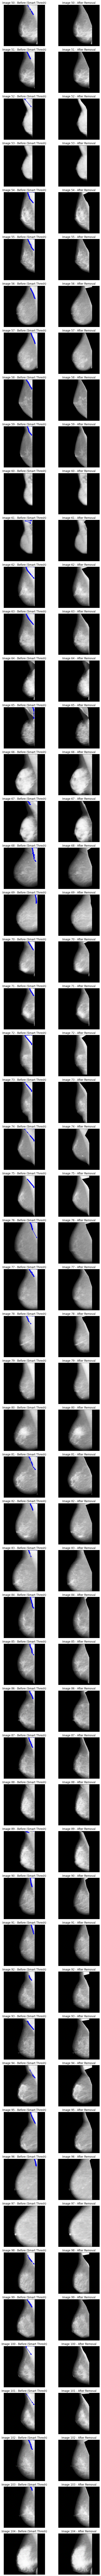

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Set your desired image range
start_idx = 50
n_images = 55

fig, axs = plt.subplots(n_images, 2, figsize=(8, 3 * n_images))

for i in range(n_images):
    idx = start_idx + i
    img = denoised[idx]
    background_thresh = np.percentile(img, 99)
    pts = rm_pec(img, background_thresh)

    # Check if pts is valid
    if pts is None or len(pts) < 10:
        print(f"[Warning] Skipping image {idx} due to no or weak contour")
        img_new = img
        ys, xs = [], []
    else:
        ys = [x[0] for x in pts]
        xs = [x[1] for x in pts]
        img_new = rm_cntrs(img, pts)

    # Plot original + overlay
    axs[i, 0].imshow(img, cmap='gray')
    if len(ys) > 0:
        axs[i, 0].plot(xs, ys, marker='.', color='blue')
    axs[i, 0].set_title(f"Image {idx} - Before (Smart Thresh)")

    # Plot after removal
    axs[i, 1].imshow(img_new, cmap='gray')
    axs[i, 1].set_title(f"Image {idx} - After Removal")

    for ax in axs[i]:
        ax.set_xticks([])
        ax.set_yticks([])

plt.tight_layout()
plt.show()
